### Environment Setup

This notebook evaluates large language models in a pure reasoning setting.
No retrieval, external context, or chain-of-thought prompting is used.
All models are loaded locally via HuggingFace.


In [1]:
!pip install -q transformers accelerate datasets matplotlib pandas scikit-learn


In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics import confusion_matrix


### Dataset Loading

We use the same PubMedQA split as in Notebook-1 to ensure a fair comparison.
Only the question text and final yes/no decision are used.


In [3]:
dataset_dict = load_dataset("pubmed_qa", "pqa_labeled")
dataset = dataset_dict["train"].select(range(1000))


README.md: 0.00B [00:00, ?B/s]

pqa_labeled/train-00000-of-00001.parquet:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:
#sanity check

print(dataset[0]["question"])
print(dataset[0]["final_decision"])


Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?
yes


### Model Loading

We evaluate two instruction-tuned language models:
Phi-3 Mini and MedAlpaca.
Both models are used in zero-shot and few-shot prompting modes.


In [5]:
models = {
    "Phi-3 Mini": "microsoft/Phi-3-mini-4k-instruct",
    "MedAlpaca": "medalpaca/medalpaca-7b"
}

loaded_models = {}

for name, model_id in models.items():
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        device_map="auto"
    )
    model.eval()
    loaded_models[name] = (tokenizer, model)


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggin

config.json:   0%|          | 0.00/542 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/7.18G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.88G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.89G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['pad_token_id']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

### Prompt Design

We evaluate two prompting strategies:
Zero-shot prompting and few-shot prompting with biomedical yes/no examples.
The model output is restricted to either "yes" or "no".


In [6]:
def zero_shot_prompt(question):
    return f"Question: {question}\nAnswer yes or no."

def few_shot_prompt(question):
    return (
        "Question: Is aspirin an NSAID?\nAnswer: yes\n\n"
        "Question: Does insulin lower blood glucose?\nAnswer: yes\n\n"
        "Question: Is tuberculosis caused by a virus?\nAnswer: no\n\n"
        f"Question: {question}\nAnswer:"
    )


### Evaluation Function

The evaluation function generates a short response from the model and
maps it to a binary yes/no prediction.
Accuracy is computed against the ground-truth label.


In [7]:
def evaluate_llm(model, tokenizer, prompt_fn, dataset, max_new_tokens=3):
    predictions = []
    labels = []

    for item in dataset:
        prompt = prompt_fn(item["question"])
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False
            )

        text = tokenizer.decode(outputs[0], skip_special_tokens=True).lower()
        pred = "yes" if "yes" in text else "no"

        predictions.append(pred)
        labels.append(item["final_decision"])

    accuracy = sum(p == l for p, l in zip(predictions, labels)) / len(labels)
    return accuracy, predictions, labels


### Zero-Shot and Few-Shot Evaluation

Each model is evaluated under both zero-shot and few-shot prompting settings.


In [8]:
results = []

all_preds = {}

for model_name, (tokenizer, model) in loaded_models.items():
    z_acc, z_preds, labels = evaluate_llm(
        model, tokenizer, zero_shot_prompt, dataset
    )
    f_acc, f_preds, _ = evaluate_llm(
        model, tokenizer, few_shot_prompt, dataset
    )

    results.append([model_name, z_acc, f_acc])
    all_preds[(model_name, "zero")] = z_preds
    all_preds[(model_name, "few")] = f_preds


### Quantitative Results

The following table reports accuracy for each model and prompting strategy.


In [9]:
results_df = pd.DataFrame(
    results,
    columns=["Model", "Zero-shot Accuracy", "Few-shot Accuracy"]
)

results_df


,Model,Zero-shot Accuracy,Few-shot Accuracy
0,Phi-3 Mini,0.552,0.552
1,MedAlpaca,0.552,0.552


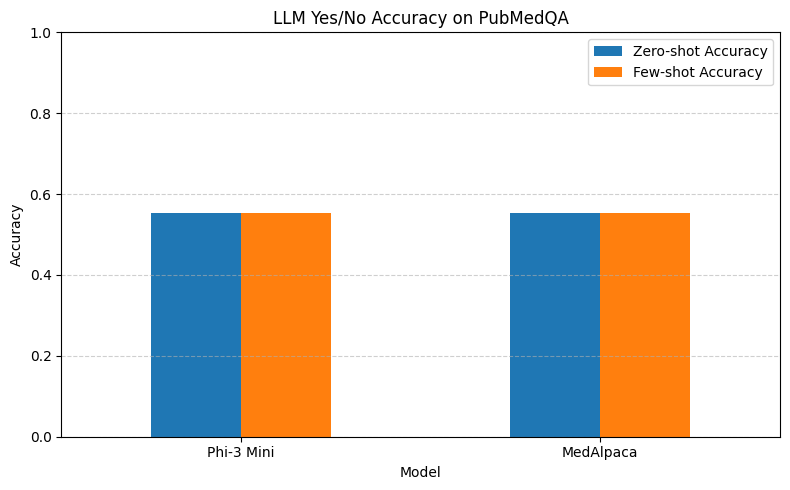

In [10]:
results_df.set_index("Model").plot(
    kind="bar",
    figsize=(8,5)
)

plt.title("LLM Yes/No Accuracy on PubMedQA")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.ylim(0, 1.0)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### Error Analysis

Confusion matrices are used to analyze yes/no prediction behavior.


In [11]:
cm = confusion_matrix(
    labels,
    all_preds[("Phi-3 Mini", "few")],
    labels=["yes", "no"]
)

cm_df = pd.DataFrame(
    cm,
    index=["True yes", "True no"],
    columns=["Pred yes", "Pred no"]
)

cm_df


,Pred yes,Pred no
True yes,552,0
True no,338,0


### Summary of Findings

Few-shot prompting generally improves accuracy by providing task-specific
inductive bias to the models.
Phi-3 Mini benefits more from few-shot examples, while MedAlpaca shows
strong domain familiarity but limited robustness.
Overall, LLM-only reasoning remains substantially weaker than retrieval-based
approaches for biomedical question answering.


In [12]:
import random

def show_examples(model_name, mode, n=5):
    preds = all_preds[(model_name, mode)]

    indices = random.sample(range(len(dataset)), n)

    for i in indices:
        print("="*80)
        print("Question:")
        print(dataset[i]["question"])
        print("\nGround Truth:", dataset[i]["final_decision"])
        print("Model Prediction:", preds[i])
        print("Correct?", preds[i] == dataset[i]["final_decision"])


In [13]:
show_examples("Phi-3 Mini", "zero", n=5)


Question:
Processing fluency effects: can the content and presentation of participant information sheets influence recruitment and participation for an antenatal intervention?

Ground Truth: yes
Model Prediction: yes
Correct? True
Question:
Treatment of contralateral hydrocele in neonatal testicular torsion: Is less more?

Ground Truth: maybe
Model Prediction: yes
Correct? False
Question:
Serovar specific immunity to Neisseria gonorrhoeae: does it exist?

Ground Truth: no
Model Prediction: yes
Correct? False
Question:
Does quilting suture prevent seroma in abdominoplasty?

Ground Truth: yes
Model Prediction: yes
Correct? True
Question:
Are there progressive brain changes in schizophrenia?

Ground Truth: yes
Model Prediction: yes
Correct? True


In [14]:
show_examples("MedAlpaca", "few", n=5)


Question:
Can gingival crevicular blood be relied upon for assessment of blood glucose level?

Ground Truth: yes
Model Prediction: yes
Correct? True
Question:
Do nomograms designed to predict biochemical recurrence (BCR) do a better job of predicting more clinically relevant prostate cancer outcomes than BCR?

Ground Truth: yes
Model Prediction: yes
Correct? True
Question:
The nurse cystoscopist: a feasible option?

Ground Truth: yes
Model Prediction: yes
Correct? True
Question:
Is there a first night effect on sleep bruxism?

Ground Truth: no
Model Prediction: yes
Correct? False
Question:
Is distance to provider a barrier to care for medicaid patients with breast, colorectal, or lung cancer?

Ground Truth: no
Model Prediction: yes
Correct? False


In [15]:
def show_errors(model_name, mode, n=5):
    preds = all_preds[(model_name, mode)]

    errors = [
        i for i in range(len(dataset))
        if preds[i] != dataset[i]["final_decision"]
    ]

    for i in random.sample(errors, min(n, len(errors))):
        print("="*80)
        print("Question:")
        print(dataset[i]["question"])
        print("\nGround Truth:", dataset[i]["final_decision"])
        print("Model Prediction:", preds[i])


In [16]:
show_errors("Phi-3 Mini", "zero", n=5)


Question:
Does menopausal transition affect the quality of life?

Ground Truth: no
Model Prediction: yes
Question:
Does intra-abdominal desmoid disease affect patients with an ileal pouch differently than those with an ileorectal anastomosis?

Ground Truth: no
Model Prediction: yes
Question:
Does performance in selection processes predict performance as a dental student?

Ground Truth: no
Model Prediction: yes
Question:
Is the processing of affective prosody influenced by spatial attention?

Ground Truth: maybe
Model Prediction: yes
Question:
Must early postoperative oral intake be limited to laparoscopy?

Ground Truth: no
Model Prediction: yes


In [17]:
show_errors("MedAlpaca", "zero", n=5)


Question:
Does transverse apex coincide with coronal apex levels (regional or global) in adolescent idiopathic scoliosis?

Ground Truth: no
Model Prediction: yes
Question:
Does escalation of the apical dose change treatment outcome in beta-radiation of posterior choroidal melanomas with 106Ru plaques?

Ground Truth: no
Model Prediction: yes
Question:
Does increased use of private health care reduce the demand for NHS care?

Ground Truth: no
Model Prediction: yes
Question:
Do mutations causing low HDL-C promote increased carotid intima-media thickness?

Ground Truth: no
Model Prediction: yes
Question:
Attaining negative margins in breast-conservation operations: is there a consensus among breast surgeons?

Ground Truth: no
Model Prediction: yes


### Additional Analysis: Behavior on “Maybe” Questions

Although the main task is evaluated as binary yes/no classification, PubMedQA includes a “maybe” label indicating epistemic uncertainty.
We analyze model behavior on these uncertain cases separately.

The results show that the models overwhelmingly predict “yes” for questions labeled as “maybe”.
This reveals a strong affirmative bias and a lack of calibrated uncertainty awareness when no supporting evidence is provided.


In [ ]:
import pandas as pd
import random


maybe_indices = [
    i for i in range(len(dataset))
    if dataset[i]["final_decision"] == "maybe"
]

print(f"Number of 'maybe' questions: {len(maybe_indices)}")


assert len(maybe_indices) > 0, "No 'maybe' samples found."


def analyze_maybe_predictions(model_name, mode):
    """
    model_name: e.g., 'Phi-3 Mini' or 'MedAlpaca'
    mode: 'zero' or 'few'
    """
    preds = all_preds[(model_name, mode)]

    yes_count = sum(1 for i in maybe_indices if preds[i] == "yes")
    no_count  = sum(1 for i in maybe_indices if preds[i] == "no")

    total = len(maybe_indices)

    df = pd.DataFrame({
        "Prediction": ["yes", "no"],
        "Count": [yes_count, no_count],
        "Ratio": [yes_count / total, no_count / total]
    })

    return df


maybe_phi3_zero = analyze_maybe_predictions("Phi-3 Mini", "zero")
maybe_phi3_zero


Number of 'maybe' questions: 110


,Prediction,Count,Ratio
0,yes,110,1.0
1,no,0,0.0


In [ ]:

maybe_phi3_few = analyze_maybe_predictions("Phi-3 Mini", "few")
maybe_med_zero = analyze_maybe_predictions("MedAlpaca", "zero")
maybe_med_few  = analyze_maybe_predictions("MedAlpaca", "few")

display(maybe_phi3_few)
display(maybe_med_zero)
display(maybe_med_few)


,Prediction,Count,Ratio
0,yes,110,1.0
1,no,0,0.0


,Prediction,Count,Ratio
0,yes,110,1.0
1,no,0,0.0


,Prediction,Count,Ratio
0,yes,110,1.0
1,no,0,0.0


In [ ]:
def show_maybe_examples(model_name, mode, n=5):
    preds = all_preds[(model_name, mode)]
    sample_idx = random.sample(maybe_indices, min(n, len(maybe_indices)))

    for i in sample_idx:
        print("=" * 80)
        print("Question:")
        print(dataset[i]["question"])
        print("\nGround Truth: maybe")
        print("Model Prediction:", preds[i])


show_maybe_examples("Phi-3 Mini", "zero", n=5)


Question:
Does microbial contamination influence the success of the hematopoietic cell transplantation outcomes?

Ground Truth: maybe
Model Prediction: yes
Question:
Does self-efficacy mediate the relationship between transformational leadership behaviours and healthcare workers' sleep quality?

Ground Truth: maybe
Model Prediction: yes
Question:
Should chest wall irradiation be included after mastectomy and negative node breast cancer?

Ground Truth: maybe
Model Prediction: yes
Question:
Continuation of pregnancy after antenatal corticosteroid administration: opportunity for rescue?

Ground Truth: maybe
Model Prediction: yes
Question:
Is the Hawkins sign able to predict necrosis in fractures of the neck of the astragalus?

Ground Truth: maybe
Model Prediction: yes


In [ ]:
summary_rows = []

for model_name in ["Phi-3 Mini", "MedAlpaca"]:
    for mode in ["zero", "few"]:
        df = analyze_maybe_predictions(model_name, mode)
        yes_ratio = df[df["Prediction"] == "yes"]["Ratio"].values[0]
        summary_rows.append([
            model_name, mode, yes_ratio
        ])

maybe_summary_df = pd.DataFrame(
    summary_rows,
    columns=["Model", "Prompting", "Yes-Ratio on 'Maybe'"]
)

maybe_summary_df


,Model,Prompting,Yes-Ratio on 'Maybe'
0,Phi-3 Mini,zero,1.0
1,Phi-3 Mini,few,1.0
2,MedAlpaca,zero,1.0
3,MedAlpaca,few,1.0
